# Stock Price Prediction


## Import & Constants


### Imports


In [1]:
import yfinance as yf

from functools import reduce

import matplotlib.pyplot as plt

import pandas as pd

import backtrader as bt

In [2]:
import pyspark.sql.functions as F

from pyspark.sql import SparkSession, DataFrame

from pyspark.sql.functions import col, year, when, sum, weekofyear, last, dayofweek, row_number, expr, to_date, udf, isnull
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Constants


In [3]:
START_DATE = '2005-01-01'
END_DATE = '2024-04-26'

BUY_NUM = 1
SELL_NUM = 2

PERC_FOR_BUY_SELL_END = 1
PERC_FOR_BUY_SELL_MID = 1

STOCK_SYMBOL = 'AMZN'

PERC_TRAIN = 0.75

RANGE_YEARS_GRAPH = 3

SEED = 42

## Download Data


In [11]:
# Spark session creation
spark = SparkSession.builder.appName("StockPricePrediction").getOrCreate()

# Function to download financial data using yfinance
def download_stock_data(symbol):
    data = yf.download(symbol, start=START_DATE, end=END_DATE)
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    return data

In [12]:
# Download data
data = download_stock_data(STOCK_SYMBOL)

# Convert Pandas dataframes to Spark dataframes
pyspark_df = spark.createDataFrame(data.reset_index())

# Display the schema and an example of the data
pyspark_df.printSchema()

[*********************100%***********************]  1 of 1 completed


root
 |-- Date: timestamp (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)



In [14]:
pyspark_df.show(5)

+-------------------+------------------+------------------+------------------+------------------+---------+
|               Date|             Close|              High|               Low|              Open|   Volume|
+-------------------+------------------+------------------+------------------+------------------+---------+
|2005-01-03 00:00:00|2.2260000705718994|2.2720000743865967|2.2105000019073486| 2.247499942779541|208930000|
|2005-01-04 00:00:00|2.1070001125335693|2.1630001068115234| 2.075000047683716| 2.133500099182129|388370000|
|2005-01-05 00:00:00|2.0885000228881836| 2.138000011444092| 2.078000068664551|2.0785000324249268|167084000|
|2005-01-06 00:00:00| 2.052500009536743| 2.112499952316284|2.0450000762939453|2.0905001163482666|174018000|
|2005-01-07 00:00:00| 2.115999937057495| 2.134500026702881| 2.058000087738037| 2.069000005722046|196732000|
+-------------------+------------------+------------------+------------------+------------------+---------+
only showing top 5 rows



## Prepare Data


### Delete incomplete rows


In [15]:
# Defines a function to check for null values in any column
def any_null(df):
    # Creates a condition that checks for null values in any column
    condition = reduce(lambda x, y: x | y, (col(c).isNull() for c in df.columns))
    return df.filter(condition)

# Applies function to DataFrame and shows rows with null values
any_null(pyspark_df).show()

+----+-----+----+---+----+------+
|Date|Close|High|Low|Open|Volume|
+----+-----+----+---+----+------+
+----+-----+----+---+----+------+



In [16]:
# Deletes rows with at least one null value
pyspark_df = pyspark_df.dropna()

print("Number of rows after cleaning:", pyspark_df.count())

Number of rows after cleaning: 4861


### Eliminate incomplete weeks


In [17]:
# Add a column 'is_monday' which is 1 if the day is Monday (2), otherwise 0
pyspark_df = pyspark_df.withColumn("is_monday", (dayofweek(col("Date")) == 2).cast("integer"))

# Add a column 'is_wednesday' which is 1 if the day is Wednesday (4), otherwise 0
pyspark_df = pyspark_df.withColumn("is_wednesday", (dayofweek(col("Date")) == 4).cast("integer"))

# Add a column 'is_friday' which is 1 if the day is Friday (5), otherwise 0
pyspark_df = pyspark_df.withColumn("is_friday", (dayofweek(col("Date")) == 6).cast("integer"))

# Show first rows to confirm new columns
pyspark_df.show(10)

+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+---------+
|               Date|             Close|              High|               Low|              Open|   Volume|is_monday|is_wednesday|is_friday|
+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+---------+
|2005-01-03 00:00:00|2.2260000705718994|2.2720000743865967|2.2105000019073486| 2.247499942779541|208930000|        1|           0|        0|
|2005-01-04 00:00:00|2.1070001125335693|2.1630001068115234| 2.075000047683716| 2.133500099182129|388370000|        0|           0|        0|
|2005-01-05 00:00:00|2.0885000228881836| 2.138000011444092| 2.078000068664551|2.0785000324249268|167084000|        0|           1|        0|
|2005-01-06 00:00:00| 2.052500009536743| 2.112499952316284|2.0450000762939453|2.0905001163482666|174018000|        0|           0|        0|
|2005-01-07 0

In [18]:
# Add a column indicating the week of the year and the year
pyspark_df = pyspark_df.withColumn("week_of_year", weekofyear(col("Date")))
pyspark_df = pyspark_df.withColumn("year", year(col("Date")))

# Define partitioned window by year and week
week_window = Window.partitionBy("year", "week_of_year")

In [19]:
# Aggregate by week and year to check attendance on Monday, Wednesdays, and Fridays
week_checks = pyspark_df.groupBy("year", "week_of_year")\
    .agg(
        sum("is_monday").alias("monday"),
        sum("is_wednesday").alias("wednesdays"),
        sum("is_friday").alias("fridays")
    )

# Filter to keep only weeks that have at least a Monday, a Wednesday, and a Friday
valid_weeks = week_checks.filter((col("monday") > 0) & (col("wednesdays") > 0) & (col("fridays") > 0))

In [20]:
# Merge the valid weeks with the original DataFrame
pyspark_df = pyspark_df.join(valid_weeks, ["year", "week_of_year"], "inner").drop('monday', 'wednesdays', 'fridays')

In [21]:
# Show the first few rows of the resulting DataFrame to confirm the change
pyspark_df.show(10)

+----+------------+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+---------+
|year|week_of_year|               Date|             Close|              High|               Low|              Open|   Volume|is_monday|is_wednesday|is_friday|
+----+------------+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+---------+
|2005|          29|2005-07-22 00:00:00|1.8975000381469727|1.9114999771118164|1.8619999885559082|1.8945000171661377|117422000|        0|           0|        1|
|2005|          29|2005-07-21 00:00:00|1.8975000381469727|1.9874999523162842|1.8880000114440918|1.9479999542236328|221112000|        0|           0|        0|
|2005|          29|2005-07-20 00:00:00|1.9084999561309814| 1.912500023841858|1.8650000095367432| 1.874500036239624|127368000|        0|           1|        0|
|2005|          29|2005-07-19 00:00:00|1.90849

### Buy & Sell


#### Monday


In [22]:
# Filter to get only Mondays and get the opening price
monday_opens = pyspark_df.filter(F.col("is_monday") == 1).select("year", "week_of_year", "Open")

# Rename the 'Open' column to 'weekly_open' for Mondays
monday_opens = monday_opens.withColumnRenamed("Open", "weekly_open")

# Creates a window specification partitioned by year and week
windowSpec = Window.partitionBy("year", "week_of_year")

# Perform a join left between the original DataFrame and the Monday DataFrame to extend 'weekly_open' to all rows of the same week
pyspark_df = pyspark_df.join(monday_opens, on=["year", "week_of_year"], how="left")

# Uses first() function on 'weekly_open' with window defined to fill all rows of the same week with Monday's open value
pyspark_df = pyspark_df.withColumn("weekly_open", F.first("weekly_open").over(windowSpec))

# Show results to confirm that the transformation is correct
pyspark_df.select("year", "week_of_year", "Date", "is_monday", "Open", "weekly_open").orderBy("year", "week_of_year", "Date").show()

+----+------------+-------------------+---------+------------------+------------------+
|year|week_of_year|               Date|is_monday|              Open|       weekly_open|
+----+------------+-------------------+---------+------------------+------------------+
|2005|           1|2005-01-03 00:00:00|        1| 2.247499942779541| 2.247499942779541|
|2005|           1|2005-01-04 00:00:00|        0| 2.133500099182129| 2.247499942779541|
|2005|           1|2005-01-05 00:00:00|        0|2.0785000324249268| 2.247499942779541|
|2005|           1|2005-01-06 00:00:00|        0|2.0905001163482666| 2.247499942779541|
|2005|           1|2005-01-07 00:00:00|        0| 2.069000005722046| 2.247499942779541|
|2005|           2|2005-01-10 00:00:00|        1|2.0969998836517334|2.0969998836517334|
|2005|           2|2005-01-11 00:00:00|        0| 2.069999933242798|2.0969998836517334|
|2005|           2|2005-01-12 00:00:00|        0|  2.07450008392334|2.0969998836517334|
|2005|           2|2005-01-13 00

#### Wednesday


In [23]:
# Find the closing price for Wednesday
mid_week_window = Window.partitionBy("year", "week_of_year").orderBy("Date").rowsBetween(Window.unboundedPreceding, Window.currentRow)
mid_week_price = pyspark_df.withColumn("row_index", F.row_number().over(mid_week_window) - 1)
mid_week_price = mid_week_price.filter(col("row_index") == 2).select("year", "week_of_year", col("Close").alias("mid_week_close"))

# Merge DataFrames to get Wednesday's close in each weekly row
pyspark_df = pyspark_df.join(mid_week_price, ["year", "week_of_year"], "left")

In [24]:
# Calculate the percentage change from Sunday to Wednesday
pyspark_df = pyspark_df.withColumn(
    "mid_week_change_perc",
    ((col("mid_week_close") - col("weekly_open")) / col("weekly_open")) * 100
)

# Add 'action_mid' column based on the percentage change calculated through Wednesday
pyspark_df = pyspark_df.withColumn(
    "action_mid",
    when(col("mid_week_change_perc") >= PERC_FOR_BUY_SELL_MID, BUY_NUM)
    .when(col("mid_week_change_perc") <= -PERC_FOR_BUY_SELL_MID, SELL_NUM)
    .otherwise(0)
)

# Show the final result
pyspark_df.select("year", "week_of_year", "Date", "is_monday", "is_wednesday", "is_friday", "Open", "Close", "mid_week_close", "mid_week_change_perc", "action_mid").show(10)

+----+------------+-------------------+---------+------------+---------+------------------+------------------+------------------+--------------------+----------+
|year|week_of_year|               Date|is_monday|is_wednesday|is_friday|              Open|             Close|    mid_week_close|mid_week_change_perc|action_mid|
+----+------------+-------------------+---------+------------+---------+------------------+------------------+------------------+--------------------+----------+
|2005|           1|2005-01-07 00:00:00|        0|           0|        1| 2.069000005722046| 2.115999937057495|2.0885000228881836|  -7.074523868272857|         2|
|2005|           1|2005-01-06 00:00:00|        0|           0|        0|2.0905001163482666| 2.052500009536743|2.0885000228881836|  -7.074523868272857|         2|
|2005|           1|2005-01-05 00:00:00|        0|           1|        0|2.0785000324249268|2.0885000228881836|2.0885000228881836|  -7.074523868272857|         2|
|2005|           1|2005-01-0

#### Friday


In [25]:
# Calculate the closing price for each week
pyspark_df = pyspark_df.withColumn("weekly_close", last(col("Close")).over(week_window))

# Calculate the weekly percentage change
pyspark_df = pyspark_df.withColumn(
    "weekly_change_perc",
    ((col("weekly_close") - col("weekly_open")) / col("weekly_open")) * 100
)

# Add 'action_end' column according to specified conditions
pyspark_df = pyspark_df.withColumn(
    "action_end",
    when(col("weekly_change_perc") >= PERC_FOR_BUY_SELL_END, BUY_NUM)
    .when(col("weekly_change_perc") <= -PERC_FOR_BUY_SELL_END, SELL_NUM)
    .otherwise(0)
)

# Show the final result
pyspark_df.select("year", "week_of_year", "Date", "is_friday", "Close", "mid_week_close", "mid_week_change_perc", "weekly_change_perc", "weekly_change_perc", "action_mid", "action_end").show(10)

+----+------------+-------------------+---------+------------------+------------------+--------------------+--------------------+--------------------+----------+----------+
|year|week_of_year|               Date|is_friday|             Close|    mid_week_close|mid_week_change_perc|  weekly_change_perc|  weekly_change_perc|action_mid|action_end|
+----+------------+-------------------+---------+------------------+------------------+--------------------+--------------------+--------------------+----------+----------+
|2005|           1|2005-01-07 00:00:00|        1| 2.115999937057495|2.0885000228881836|  -7.074523868272857| -0.9566128033379239| -0.9566128033379239|         2|         0|
|2005|           1|2005-01-06 00:00:00|        0| 2.052500009536743|2.0885000228881836|  -7.074523868272857| -0.9566128033379239| -0.9566128033379239|         2|         0|
|2005|           1|2005-01-05 00:00:00|        0|2.0885000228881836|2.0885000228881836|  -7.074523868272857| -0.9566128033379239| -0.95

#### Checks null values


In [26]:
# Checks all columns for null values
for column in pyspark_df.columns:
    nulls_in_column = pyspark_df.filter(col(column).isNull()).count()
    if nulls_in_column > 0:
        print(f"Column '{column}' has {nulls_in_column} rows with null values")

### Chart to visualize how many weeks are to buy or sell


In [27]:
# Calculate the range of years
pyspark_df = pyspark_df.withColumn("Year_Range", ((col("Year") - int(START_DATE[:4])) / RANGE_YEARS_GRAPH).cast("int") * RANGE_YEARS_GRAPH + int(START_DATE[:4]))

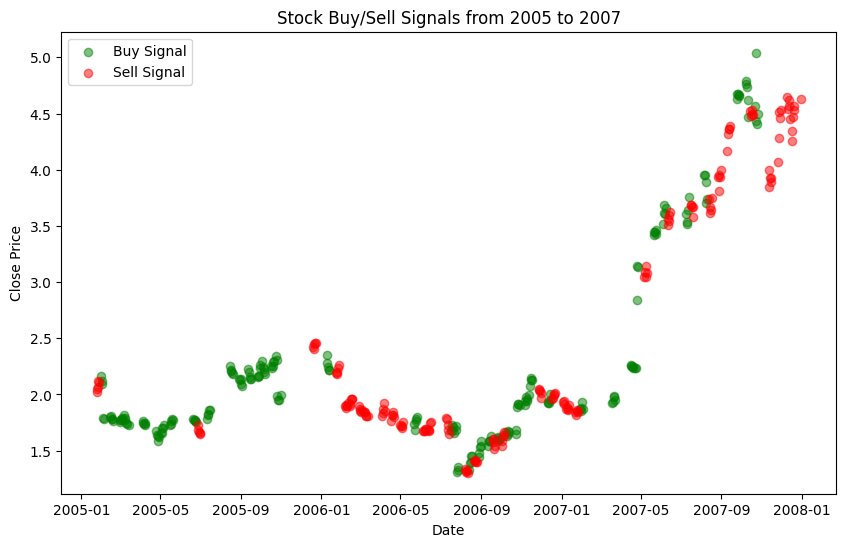

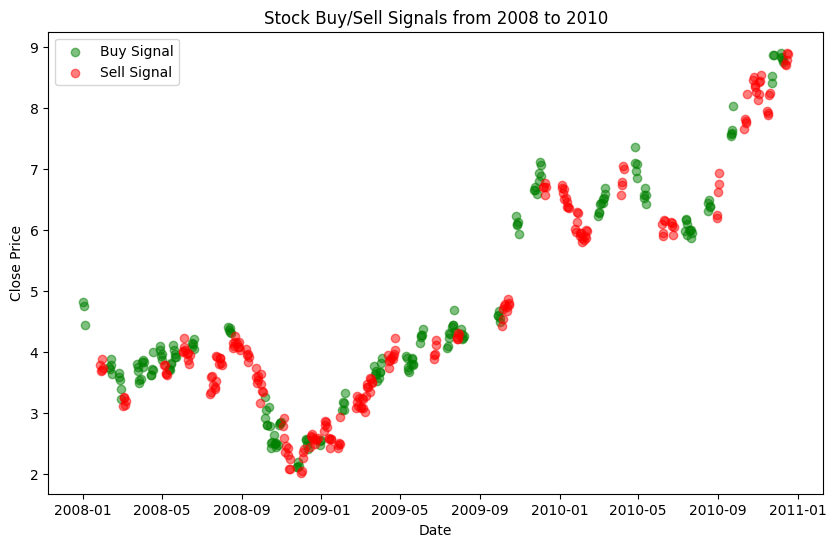

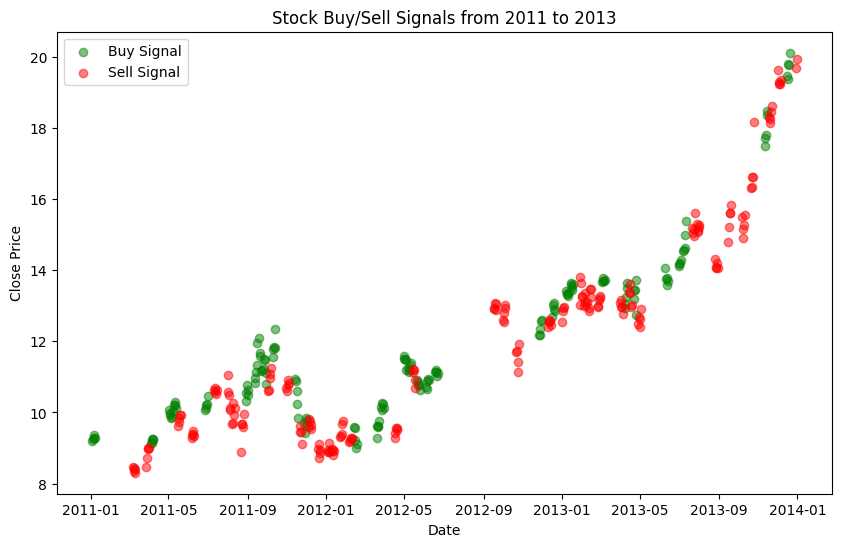

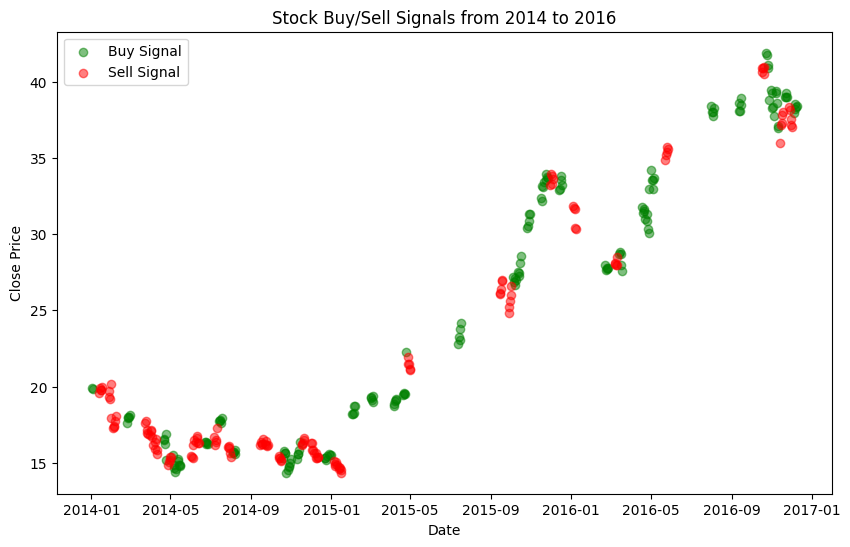

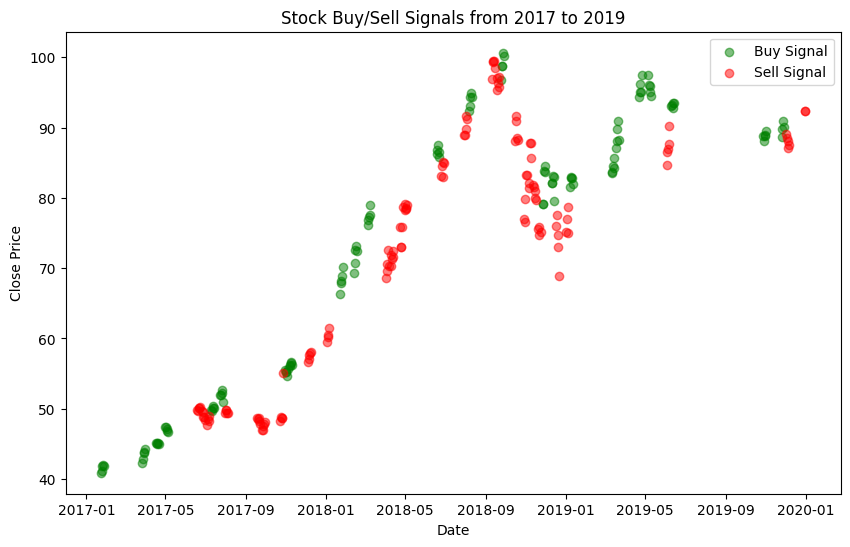

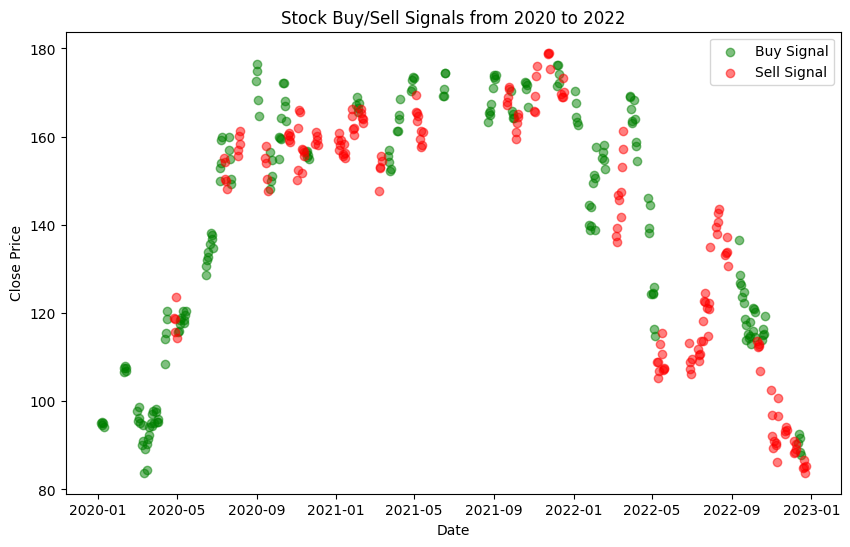

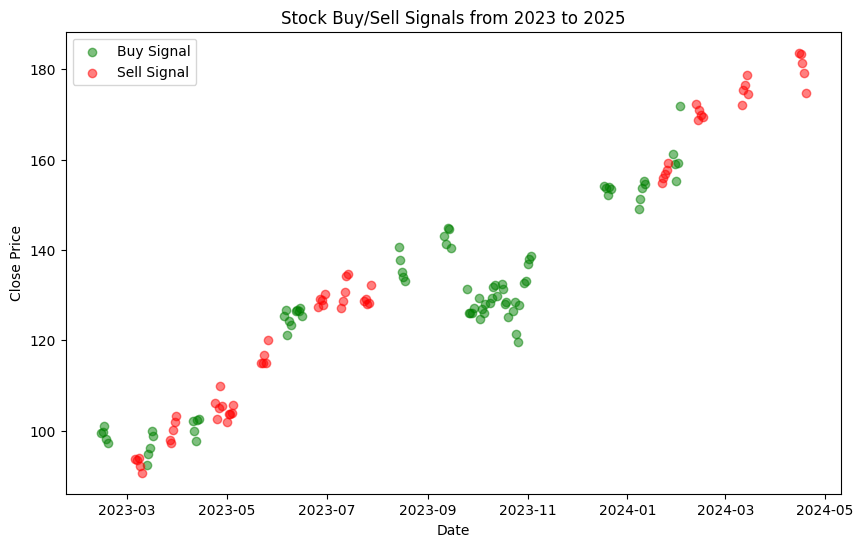

In [28]:
# Calculate the range of years present
year_ranges = pyspark_df.select("Year_Range").distinct().orderBy("Year_Range").collect()

for year_range in year_ranges:
    # Filter the DataFrame for the specific range of years
    filtered_df = pyspark_df.filter(col("Year_Range") == year_range.Year_Range)

    # Convert to Pandas DataFrame
    pandas_df = filtered_df.toPandas()

    # Create a chart
    plt.figure(figsize=(10, 6))

    # Plot data where action_end is BUY_NUM
    buy_signals = pandas_df[pandas_df['action_end'] == BUY_NUM]
    plt.scatter(buy_signals['Date'], buy_signals['Close'], color='green', label='Buy Signal', alpha=0.5)

    # Plot data where action_end is SELL_NUM
    sell_signals = pandas_df[pandas_df['action_end'] == SELL_NUM]
    plt.scatter(sell_signals['Date'], sell_signals['Close'], color='red', label='Sell Signal', alpha=0.5)

    # Labeling
    plt.title(f'Stock Buy/Sell Signals from {year_range.Year_Range} to {year_range.Year_Range + RANGE_YEARS_GRAPH - 1}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    #plt.show()

pyspark_df = pyspark_df.drop('Year_Range')

## Prediction


### Preparation for prediction


In [29]:
# Calculates the total number of rows
total_rows = pyspark_df.count()

# Calculates the index of the row at PERC_TRAIN%
eighty_percent_index = int(PERC_TRAIN * total_rows)

# Sort the DataFrame by date
sorted_pyspark_df = pyspark_df.orderBy("Date")

# Add a numbering column to the rows
windowSpec = Window.orderBy("Date")
sorted_pyspark_df = sorted_pyspark_df.withColumn("row_number", row_number().over(windowSpec))

# Find the date at PERC_TRAIN% of the DataFrame
date_threshold_row = sorted_pyspark_df.filter(col("row_number") == eighty_percent_index).select("Date")

# Extract the date as a string
date_threshold = date_threshold_row.collect()[0]['Date']

# Check the day of the week
# dayofweek() returns an integer from 1 (Sunday) to 7 (Saturday)
day_of_week = date_threshold_row.withColumn("day_of_week", dayofweek("Date"))

# If it is not Monday (2), calculate the previous Monday
monday_threshold = day_of_week.withColumn("MondayDate",
                                          expr("date_sub(Date, IF(dayofweek(Date)=1, 6, dayofweek(Date)-2))"))
# Extract Monday as string
date_threshold = monday_threshold.collect()[0]['MondayDate'].strftime("%Y-%m-%d")

# Print the result
print(f"Day that roughly corresponds to {PERC_TRAIN*100}% of the range, corrected as Monday: {date_threshold}")

Day that roughly corresponds to 75.0% of the range, corrected as Monday: 2019-06-17


In [30]:
# Filter the DataFrame to include only Wednesday or Friday
filtered_df = pyspark_df.filter((col("is_wednesday") == 1))

features = ["action_mid", "mid_week_change_perc", "Volume"]

# Remove rows with missing values in the specified columns
filtered_df = filtered_df.dropna(subset=features)

# Training data
train_data = filtered_df.filter(col("Date") < date_threshold)
# Data for the test
test_data = filtered_df.filter(col("Date") >= date_threshold)

print("Number of rows in the training set:", train_data.count())
print("Number of rows in the test set:", test_data.count())

Number of rows in the training set: 646
Number of rows in the test set: 215


In [31]:
train_data.show(5)

+----+------------+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+---------+------------------+------------------+--------------------+----------+------------------+--------------------+----------+
|year|week_of_year|               Date|             Close|              High|               Low|              Open|   Volume|is_monday|is_wednesday|is_friday|       weekly_open|    mid_week_close|mid_week_change_perc|action_mid|      weekly_close|  weekly_change_perc|action_end|
+----+------------+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+---------+------------------+------------------+--------------------+----------+------------------+--------------------+----------+
|2005|           1|2005-01-05 00:00:00|2.0885000228881836| 2.138000011444092| 2.078000068664551|2.0785000324249268|167084000|        0|           1|        0| 2

### Random Forest Classifier Prediction


In [32]:
# Define features with VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Define the classification model
classifier = RandomForestClassifier(labelCol="action_end", featuresCol="features", seed=SEED)

# Build the pipeline
pipeline = Pipeline(stages=[assembler, classifier])

# Pattern training
try:
    model = pipeline.fit(train_data)
    # Prediction on the test set
    predictions = model.transform(test_data)

    # Set up the evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol="action_end", predictionCol="prediction")

    # Evaluate accuracy
    evaluator.setMetricName("accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test Accuracy = %g" % accuracy)
    
    # Evaluate weighted precision
    evaluator.setMetricName("weightedPrecision")
    weightedPrecision = evaluator.evaluate(predictions)
    print("Weighted Precision = %g" % weightedPrecision)
    
    # Evaluate weighted recall
    evaluator.setMetricName("weightedRecall")
    weightedRecall = evaluator.evaluate(predictions)
    print("Weighted Recall = %g" % weightedRecall)
    
    # Evaluate F1-Score
    evaluator.setMetricName("f1")
    f1 = evaluator.evaluate(predictions)
    print("F1 Score = %g" % f1)

except Exception as e:
    print(f"Error during training or evaluation: {str(e)}")

Test Accuracy = 0.55814
Weighted Precision = 0.556148
Weighted Recall = 0.55814
F1 Score = 0.555694


### Probability Analysis


In [33]:
# Show confusion matrix
predictions.groupBy("action_end", "prediction").count().show()

+----------+----------+-----+
|action_end|prediction|count|
+----------+----------+-----+
|         2|       1.0|    3|
|         1|       0.0|   21|
|         0|       2.0|   16|
|         0|       0.0|   69|
|         1|       2.0|   11|
|         2|       2.0|   22|
|         1|       1.0|   29|
|         2|       0.0|   24|
|         0|       1.0|   20|
+----------+----------+-----+



In [34]:
# Define UDF to extract each probability from the array
get_prob_0 = udf(lambda probs: float(probs[0]), FloatType())
get_prob_1 = udf(lambda probs: float(probs[BUY_NUM]), FloatType())
get_prob_2 = udf(lambda probs: float(probs[SELL_NUM]), FloatType())

# Apply UDFs to create new columns in the DataFrame
predictions = predictions.withColumn("prob_hold", get_prob_0("probability"))
predictions = predictions.withColumn("prob_buy", get_prob_1("probability"))
predictions = predictions.withColumn("prob_sell", get_prob_2("probability"))

# Show the updated DataFrame
predictions.select("prob_hold", "prob_buy", "prob_sell").show(7)

+----------+-----------+-----------+
| prob_hold|   prob_buy|  prob_sell|
+----------+-----------+-----------+
|0.58392423|  0.3633993|  0.0526765|
| 0.7426239|0.057200566| 0.20017551|
| 0.6748295|  0.2756566|0.049513903|
|0.27139756|  0.6120015| 0.11660093|
|0.56795174|0.054068852|  0.3779794|
|0.62830204|  0.3296461|0.042051822|
| 0.4182277| 0.05659832| 0.52517396|
+----------+-----------+-----------+
only showing top 7 rows



In [35]:
# Perform a "left" join to make sure all rows of pyspark_df are maintained
pyspark_df_predicted = pyspark_df.join(
    predictions.select("year", "week_of_year", "prob_hold", "prob_buy", "prob_sell", "prediction"),
    on=["year", "week_of_year"],
    how="left"
).drop('Year', 'week_of_year', 'weekly_open', 'mid_week_close', 'mid_week_change_perc', 'weekly_close', 'weekly_change_perc', 'action_mid', 'is_monday')

# Make sure 'Date' is a column of type date, if it is not already so convert it
pyspark_df_predicted = pyspark_df_predicted.withColumn("Date", to_date(col("Date")))

# Filter the DataFrame to include only dates after date_threshold
pyspark_df_predicted = pyspark_df_predicted.filter(col("Date") >= date_threshold)

# Sort the filtered DataFrame by the 'Date' column
pyspark_df_predicted = pyspark_df_predicted.orderBy(col("Date"))

#### Compare the prediction and actual values graphically


In [36]:
# Filter to get only rows matching Fridays
friday_predictions = pyspark_df_predicted.filter(col("is_friday") == 1).select('Date', 'prediction', 'action_end')

# Convert the Spark DataFrame to a pandas DataFrame
friday_predictions_pd = friday_predictions.toPandas()

friday_predictions_pd.head(5)

,Date,prediction,action_end
0,2019-06-21,0.0,0
1,2019-06-28,0.0,0
2,2019-07-05,0.0,0
3,2019-07-12,1.0,0
4,2019-07-19,0.0,0


In [37]:
def graph_pred_actual(ax, part, title):
    ax.plot(part['Date'].values, part['prediction'].values, label='Predicted Action End', color='orange', marker='x')
    ax.plot(part['Date'].values, part['action_end'].values, label='Actual Action End', color='lightskyblue', marker='o')
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Action End Value')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

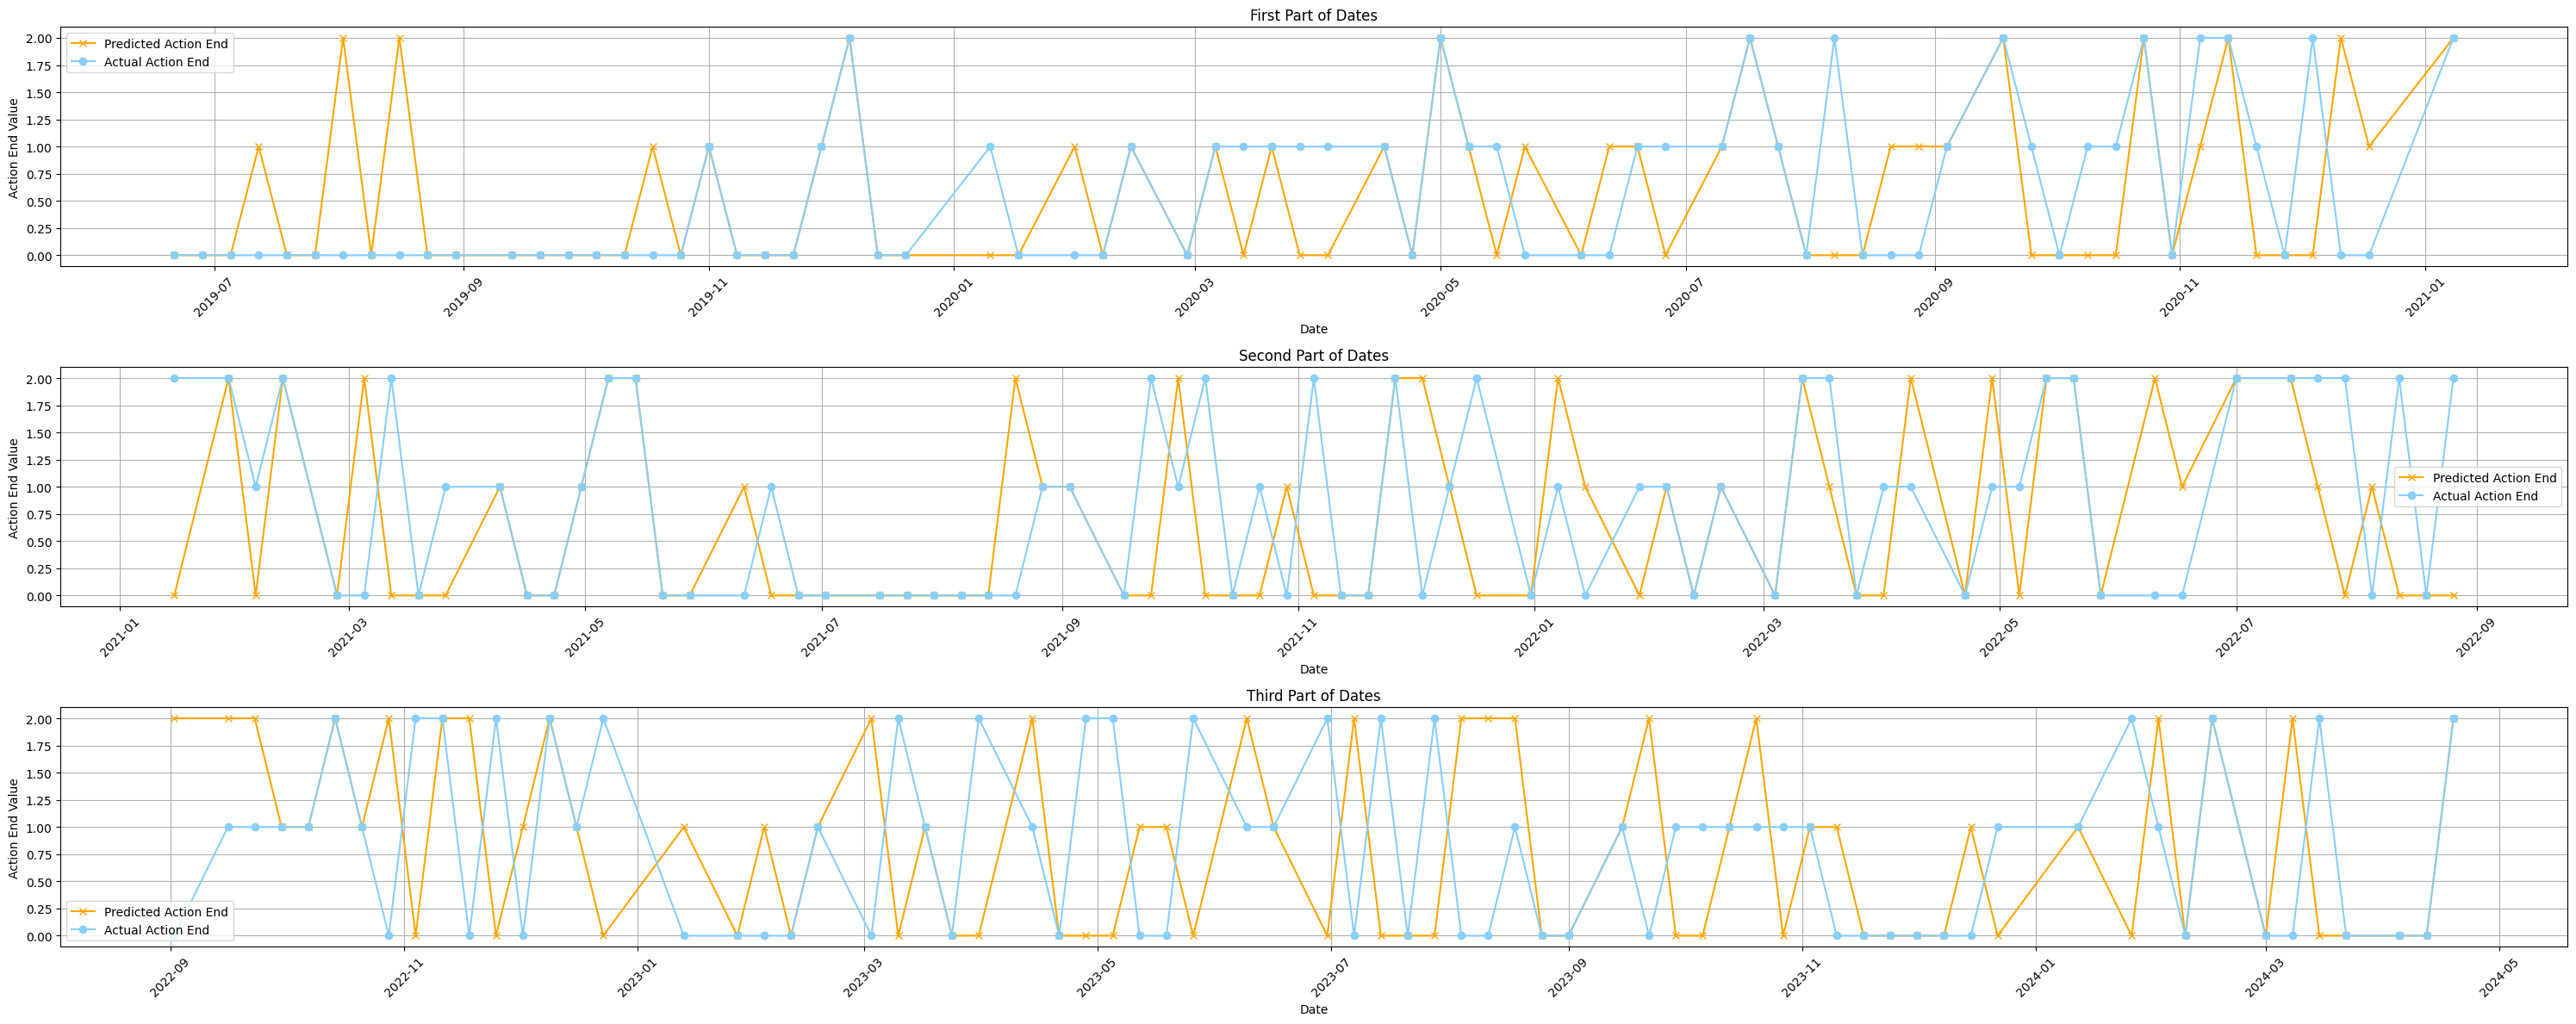

In [38]:
# Calculate the division points
split1 = len(friday_predictions_pd) // 3
split2 = 2 * len(friday_predictions_pd) // 3

# Divide the data into three parts
first_part = friday_predictions_pd.iloc[:split1]
second_part = friday_predictions_pd.iloc[split1:split2]
third_part = friday_predictions_pd.iloc[split2:]

# Create the figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 12))  # Create three vertical subplots

graph_pred_actual(ax1, first_part, 'First Part of Dates')
graph_pred_actual(ax2, second_part, 'Second Part of Dates')
graph_pred_actual(ax3, third_part, 'Third Part of Dates')

# Adjusts layout to avoid label cuts
plt.tight_layout()

## Backtesting


### Data preparation for Backtrader


In [39]:
pyspark_df_predicted_pd = pyspark_df_predicted.drop('action_end').toPandas()

pyspark_df_predicted_pd['Date'] = pd.to_datetime(pyspark_df_predicted_pd['Date'])

# Set the 'Date' column as the index of the DataFrame
pyspark_df_predicted_pd.set_index('Date', inplace=True)

In [40]:
pyspark_df_predicted_pd.head(5)

,Close,High,Low,Open,Volume,is_wednesday,is_friday,prob_hold,prob_buy,prob_sell,prediction
Date,,,,,,,,,,,
2019-06-17,94.301498,94.784500,93.772499,93.824997,52686000,0,0,0.583924,0.363399,0.052676,0.0
2019-06-18,95.068497,96.083504,94.989502,95.067497,77914000,0,0,0.583924,0.363399,0.052676,0.0
2019-06-19,95.439499,95.978996,94.623497,95.391998,57906000,1,0,0.583924,0.363399,0.052676,0.0
2019-06-20,95.909500,96.760002,95.290001,96.666496,64344000,0,0,0.583924,0.363399,0.052676,0.0
2019-06-21,95.565002,96.297501,95.378998,95.805000,78672000,0,1,0.583924,0.363399,0.052676,0.0


### Add data to Backtradere


In [41]:
# Extend PandasData to include custom fields
class ExtendedPandasData(bt.feeds.PandasData):
    # Add a specification for each custom field
    # To access these lines directly
    lines = ('prediction', 'is_wednesday', 'is_friday', 'prob_buy', 'prob_sell',)
    params = (
        ('prediction', -1),  # -1 means that there is no 'prediction' column in the DataFrame pandas by default
        ('is_wednesday', -1),
        ('is_friday', -1),
        ('prob_buy', -1),  # Index of the probability of buy
        ('prob_sell', -1),  # Index of the probability of sell
    )

In [42]:
# Use the new extended data class to load data
data = ExtendedPandasData(dataname=pyspark_df_predicted_pd)

### Define the Strategy


In [43]:
class StockPricePredictionProbabilityStrategy(bt.Strategy):
  params = (('prob_threshold_buy', 0.7),
            ('prob_threshold_sell', 0.6),)

  def __init__(self):
    self.prediction = self.datas[0].prediction
    self.is_wednesday = self.datas[0].is_wednesday
    self.is_friday = self.datas[0].is_friday
    self.prob_buy = self.datas[0].prob_buy
    self.prob_sell = self.datas[0].prob_sell

  def next(self):
    #print(f"Today is Wednesday: {self.is_wednesday[0]}, Prediction: {self.prediction[0]}, Prob Buy: {self.prob_buy[0]}, Prob Sell: {self.prob_sell[0]}")
    if self.is_wednesday[0] == 1:
        if self.prediction[0] == BUY_NUM and self.prob_buy[0] >= self.p.prob_threshold_buy:
            self.buy()
        elif self.prediction[0] == SELL_NUM and self.prob_sell[0] >= self.p.prob_threshold_sell:
            self.sell()
    elif self.is_friday[0] == 1:
        if self.position:
            self.close()

### Evaluate the results


In [44]:
plt.style.use("default")
plt.rcParams["figure.figsize"] = (35,10)

In [45]:
def run_strategy_backtrader(d, strategy, params = {'prob_threshold_buy': 0, 'prob_threshold_sell': 0}):
    # Set initial capital and create an instance of Cerebro
    initial_cash = 500
    
    cerebro = bt.Cerebro()
    
    # Add data
    cerebro.adddata(d)
    
    # Add the strategy with the unpacked parameters
    cerebro.addstrategy(strategy, **params)

    # Add TradeAnalyzer to Cerebro
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyzer")

    cerebro.broker.setcash(initial_cash)
    
    # Run the backtesting
    strategies = cerebro.run()
    
    strategy = strategies[0]
    
    # Calculate and print final profit
    final_value = cerebro.broker.getvalue()
    profit = (final_value - initial_cash) / initial_cash * 100
    print(f"Profit: {profit:.2f}%")
    
    # Access the TradeAnalyzer results
    trades = strategy.analyzers.trade_analyzer.get_analysis()
    
    # Print total trades, won and lost
    total_trades = trades.total.closed
    won_trades = trades.won.total
    lost_trades = trades.lost.total
    
    print(f"Total Trades: {total_trades}")
    print(f"Won Trades: {won_trades}")
    print(f"Lost Trades: {lost_trades}")
    
    # Plot the graph of the execution
    cerebro.plot()

#### First Strategy


In [46]:
run_strategy_backtrader(data, StockPricePredictionProbabilityStrategy)

Profit: -1.67%
Total Trades: 100
Won Trades: 48
Lost Trades: 52


<IPython.core.display.Javascript object>

#### Second Strategy (considering the probability of the correctness of the values)


In [47]:
params = {'prob_threshold_buy': 0.7, 'prob_threshold_sell': 0.6}
run_strategy_backtrader(data, StockPricePredictionProbabilityStrategy, params)

Profit: 0.31%
Total Trades: 18
Won Trades: 9
Lost Trades: 9


<IPython.core.display.Javascript object>